# Tarea Semana 7 — RNN
**Equipo:** Alan De Loa, Leonardio Lopez, Isaac Zaragoza, Luis Diaz, Luis Guzman 
**Fecha:** 11-11-2025

**Objetivo:** En esta tarea se busca implementar un modelo de Deep Learning que utilice una **Red Neuronal Recurrente (RNN)** para modelar y predecir el comportamiento de una serie temporal. En particular, en esta tarea se pretende predecir el precio de cierre del Bitcoin para el día siguiente, utilizando los datos históricos del mercado. 

El objetivo principal es analizar si una red recurrente puede **capturar patrones temporales y tendencias** en un mercado tan volatil como lo es el del Bitcoin, evvaluando el desempeño con métricas de error y comparando diferentes configuraciones del modelo.

## 1) Introducción (5%)

En este notebook modelamos un problema de **predicción de series de tiempo** utilizando una **Red Neuronal Recurrente (RNN)**. Para ello utilizaremos el dataset histórico de precios del Bitcoin, obtenido de Kaggle, que contiene información diaria de mercado como precios de apertura, cierre, máximos, mínimos y volumen de transacciones.

Con este trabajo se busca poder predecir el **precio de cierre del Bitcoin del día siguiente**, a partir de los precios observados en los días anteriores. Este tipo de problema es representativo de los desafíos en contextos reales, ya que los precios financieros son muy volátiles y cuentan con patrones no lineales que dificultan su modelado con técnicas tradicionales.


## 2) Exploración, explicación y limpieza de datos (20%)

**Fuente y contexto del dataset:**  
El dataset utilizado proviene de **Kaggle**, bajo el nombre **"Bitcoin Historical Data"**, publicado por Michael Zielinski. Este conjunto de datos contiene un **histórico de los precios de Bitcoin con datos registrados cada minuto**, desde el año 2012 hasta la actualidad.

El objetivo del uso de este Dataset es **analizar el comportamiento temporal del Bitcoin** y preparar los datos para que un modelo de **RNN** pueda **predecir el precio de cierre del día siguiente**.

El dataset cuenta con 7,288,957 registros de precios y las siguientes variables principales:
| Columna | Descripción          |
|-----------|----------------|
| `Timestamp`  | Fecha de registro de mercado |
| `Open`  | Precio de apertura del día |
| `High`  | Precio máximo alcanzado en el día |
| `Low`  | Precio mínimo del día |
| `Close`  | Precio de cierre en el día |
| `Volume`  | Volumen total de transacciones realizadas |

**Exploración inicial de los datos:**
- Se verificó que el dataset contiene valores númericos correspondientes a precios y volúmenes, además de una columna de fecha llamada `Timestamp`
- Los datos se ordenaron cronológicamente para preservar la secuencia temporal.
- Al graficar las variables `Open`, `High`, `Low` y `Close` nos dimos cuenta que todas mantienen una **tendencia prácticamente idéntica**, mostrando los mismos picos y caidas a través del tiempo, lo cual es algo normal.

**Análisis de correlación**
Se calculo la matriz de correlación entre las variables de precios y se obtuvieron valores muy cercanos a 1.0, lo que indica una correlación perfecta. Debido a esto, se decidió utilizar **únicamente la variable `Close`** como representación del comportamiento del precio.

Primeras filas:


,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


Primeras filas del dataset diario:


,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01,4.58,4.84,4.58,4.84,10.000000
2012-01-02,4.84,5.00,4.84,5.00,10.100000
2012-01-03,5.00,5.32,5.00,5.29,107.085281
2012-01-04,5.29,5.57,4.93,5.57,107.233260
2012-01-05,5.57,6.46,5.57,6.42,70.328742



Matriz de correlación (datos diarios):


,Open,High,Low,Close
Open,1.000000,0.999731,0.999605,0.999459
High,0.999731,1.000000,0.999478,0.999747
Low,0.999605,0.999478,1.000000,0.999697
Close,0.999459,0.999747,0.999697,1.000000


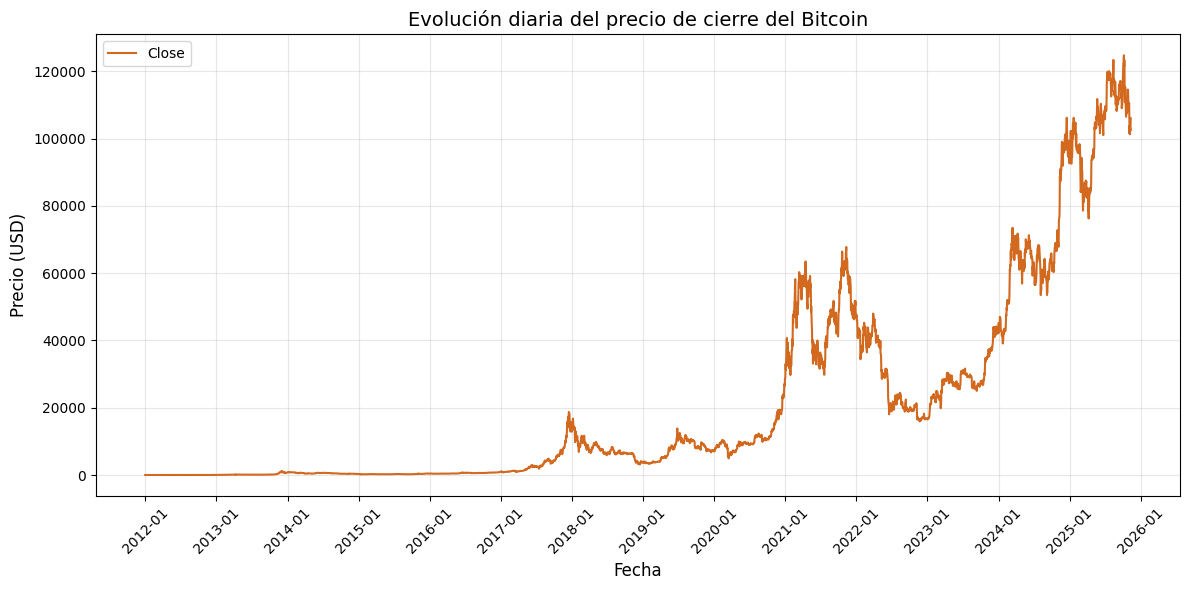

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Cargar datos
data = pd.read_csv("bitcoin.csv")
print("Primeras filas:")
display(data.head())

if pd.api.types.is_numeric_dtype(data['Timestamp']):
    data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')
else:
    # Si ya es string tipo fecha, convertirlo directamente
    data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')

# Eliminar fechas inválidas y ordenar cronológicamente
data = data.dropna(subset=['Timestamp'])
data = data.sort_values(by='Timestamp').reset_index(drop=True)

# Convertir datos de minuto a diario
data = data.set_index('Timestamp')
daily_data = data.resample('1D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna()
print("Primeras filas del dataset diario:")
display(daily_data.head())

# Matriz de correlacion
print("\nMatriz de correlación (datos diarios):")
display(daily_data[['Open', 'High', 'Low', 'Close']].corr())

# Gráfica
plt.figure(figsize=(12,6))
plt.plot(daily_data.index, daily_data['Close'], color='chocolate', linewidth=1.5, label='Close')
plt.legend()
plt.title('Evolución diaria del precio de cierre del Bitcoin', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio (USD)', fontsize=12)
# Formatear eje X (fecha)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



In [31]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler


# Normalización y creación de secuencias

# Funcion para preparar datos
def preparar_datos(data, window_size):
    close_prices = data[['Close']].values

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_prices = scaler.fit_transform(close_prices)

    X, y = [], []
    for i in range(window_size, len(scaled_prices)):
        X.append(scaled_prices[i - window_size:i, 0])
        y.append(scaled_prices[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    return X_train, X_test, y_train, y_test, scaler

Limpieza y Transformación
- Datos faltantes: el dataset no contiene valores nulos ni duplicados.
- Conversión de fechas: La columna `Timestamp` se encontraba en formato númerico (segundos desde 1970), por lo que se convirtió al tipo `datetime`. Esto nos permitió ordenar registros cronológicamente.
- Reescalado temporal: Los datos originales estaban registrados por minuto, por lo que se aplicó un proceso de resampleo diario mediante `resample('1D')`. Esto permitió reducir el ruido de alta frecuencia y obtener un resumen mas representativo.
- Selección de variables: Se seleccionó únicamente la columna `Close` como variable representativa del comportamiento del precio.
- Escala de características: Se aplicó una normalización de los precios utilizando la clase `MinMaxScaler()`. Esto mejora la estabilidad númerica.
- Estructura de secuencias: Los datos fueron organizados en **ventanas deslizantes de 7 días**, donde cada muestra contiene los precios de cierre de los 7 días anteriores y el valor objetivo es el **precio cierre del día siguiente**.

## 3) Desarrollo del Modelo de Deep Learning (25%)

In [29]:
def entrenar_modelo(tipo, X_train, y_train, X_test, y_test, scaler, window_size):
    print(f"\n Entrenando modelo {tipo} con ventana = {window_size} días...")

    # Selección del modelo
    if tipo == "RNN":
        model = Sequential([
            SimpleRNN(64, activation='tanh', input_shape=(X_train.shape[1], 1)),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1)
        ])
    elif tipo == "LSTM":
        model = Sequential([
            LSTM(64, activation='tanh', input_shape=(X_train.shape[1], 1)),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1)
        ])
    else:
        raise ValueError("Tipo de modelo no reconocido (usa 'RNN' o 'LSTM')")

    # Compilación y entrenamiento
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=16,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=0
    )

    # Predicciones
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Métricas
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    r2 = r2_score(y_test_inv, y_pred_inv)

    print(f"📊 {tipo} ({window_size} días) -> MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.4f}")

    # Graficar pérdidas
    plt.figure(figsize=(10,4))
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title(f'Curvas de pérdida ({tipo}) - ventana {window_size} días')
    plt.xlabel('Épocas')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Graficar predicciones
    plt.figure(figsize=(12,6))
    plt.plot(y_test_inv, label='Precio real', color='black', linewidth=1.5)
    plt.plot(y_pred_inv, label=f'Predicción {tipo}', linewidth=1.3)
    plt.title(f'Predicción del precio de cierre del Bitcoin ({tipo}) - ventana {window_size} días')
    plt.xlabel('Días')
    plt.ylabel('Precio (USD)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return mae, rmse, r2


 Entrenando modelo RNN con ventana = 7 días...


c:\Users\alanm\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
📊 RNN (7 días) -> MAE: 3038.39 | RMSE: 4210.56 | R²: 0.9822


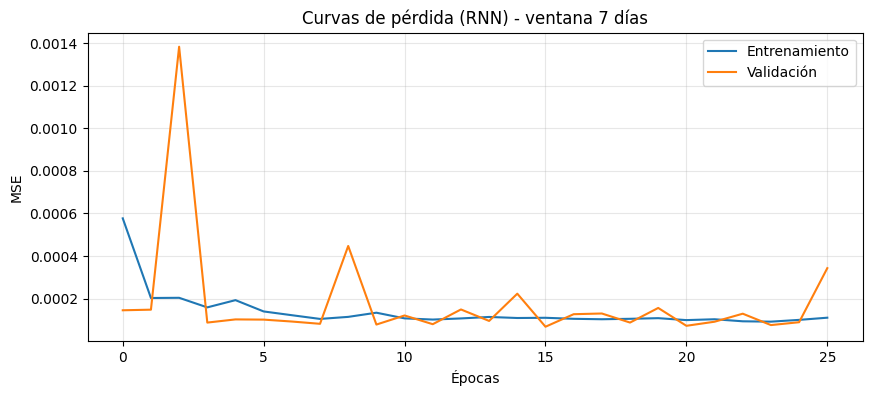

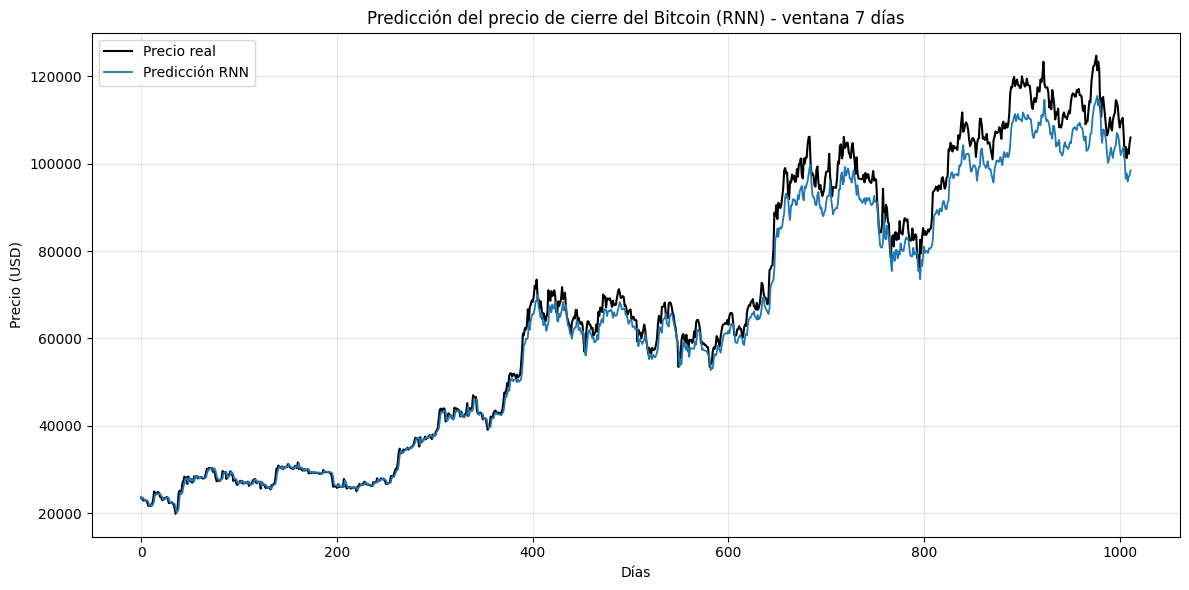


 Entrenando modelo LSTM con ventana = 7 días...


c:\Users\alanm\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
📊 LSTM (7 días) -> MAE: 3329.74 | RMSE: 4533.06 | R²: 0.9794


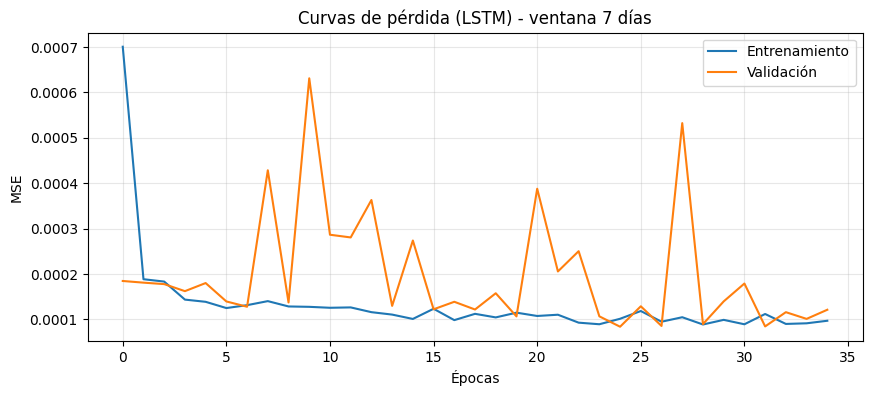

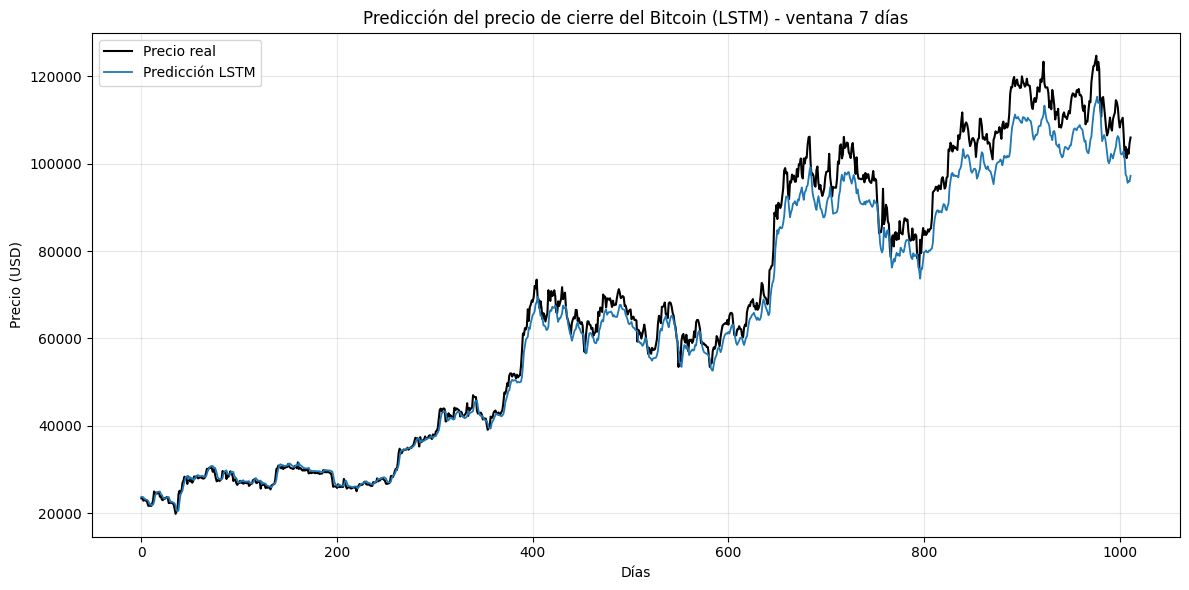


 Entrenando modelo RNN con ventana = 14 días...


c:\Users\alanm\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
📊 RNN (14 días) -> MAE: 2162.77 | RMSE: 3014.66 | R²: 0.9909


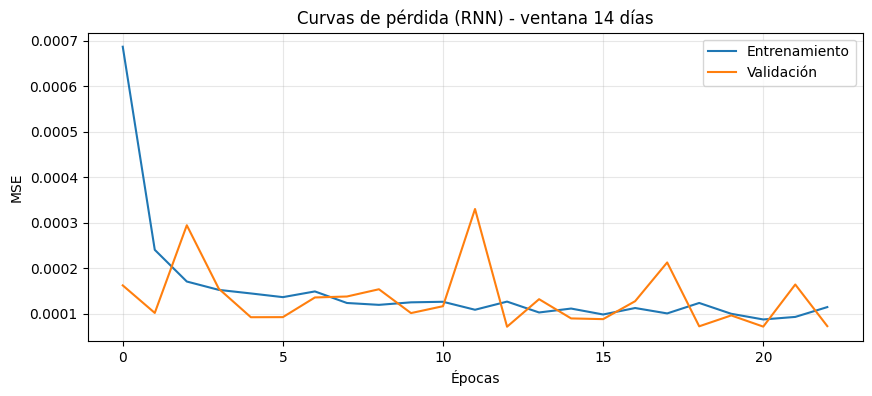

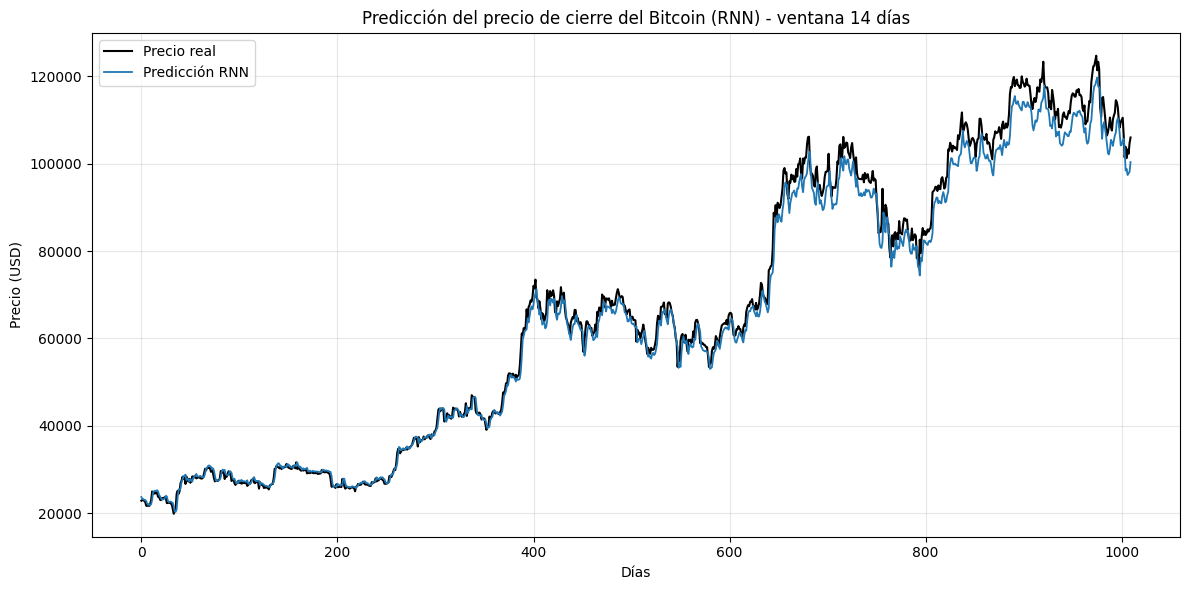


 Entrenando modelo LSTM con ventana = 14 días...


c:\Users\alanm\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
📊 LSTM (14 días) -> MAE: 4418.89 | RMSE: 5997.42 | R²: 0.9639


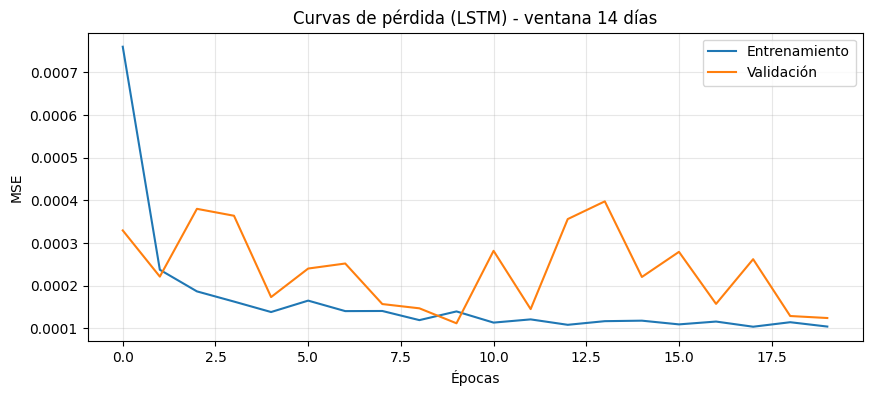

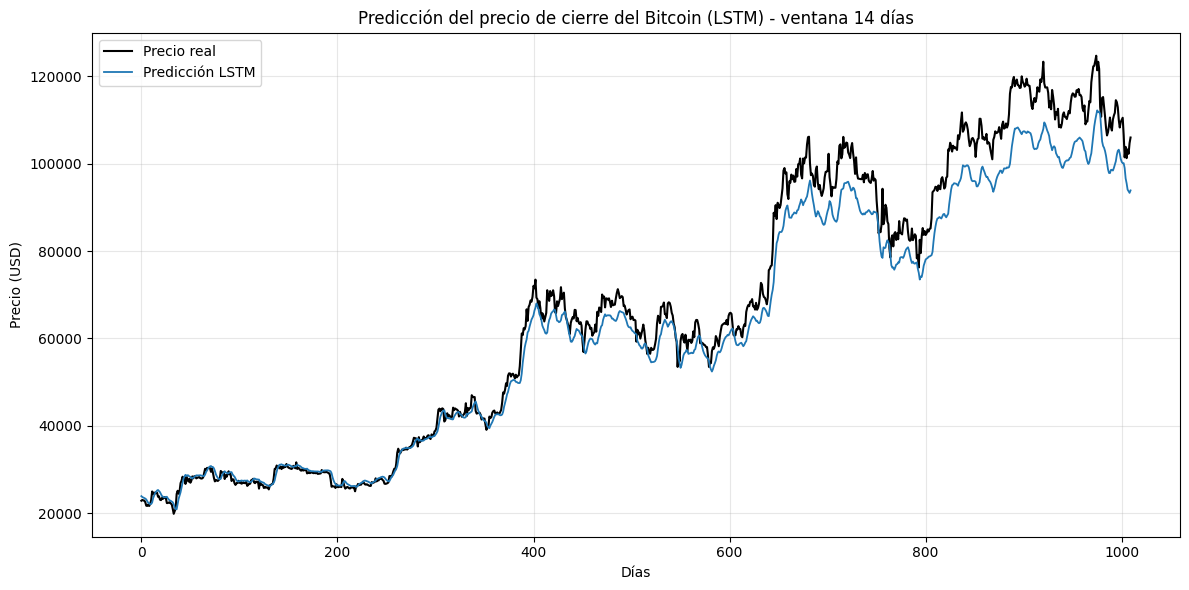


 Entrenando modelo RNN con ventana = 30 días...


c:\Users\alanm\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
📊 RNN (30 días) -> MAE: 4186.04 | RMSE: 5677.28 | R²: 0.9676


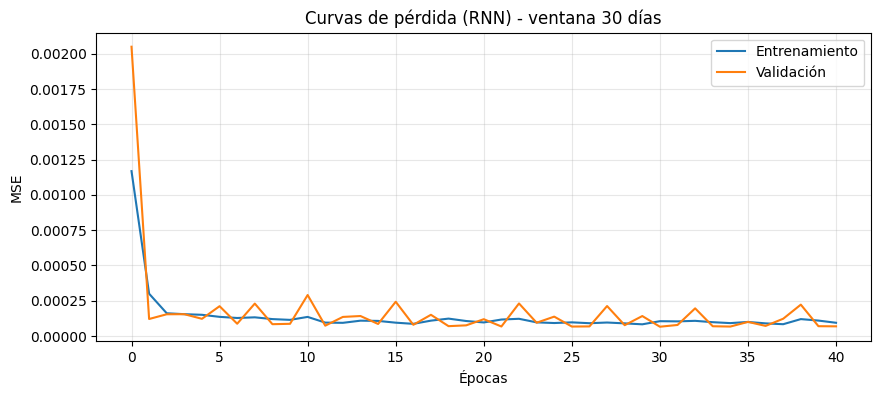

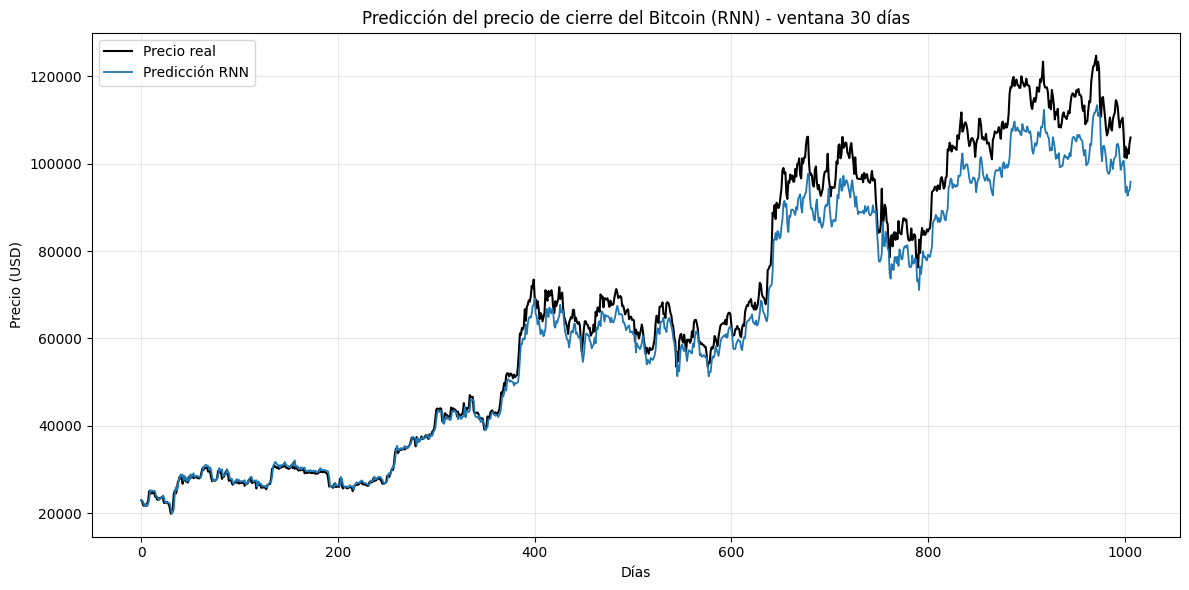


 Entrenando modelo LSTM con ventana = 30 días...


c:\Users\alanm\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
📊 LSTM (30 días) -> MAE: 4046.99 | RMSE: 5773.82 | R²: 0.9665


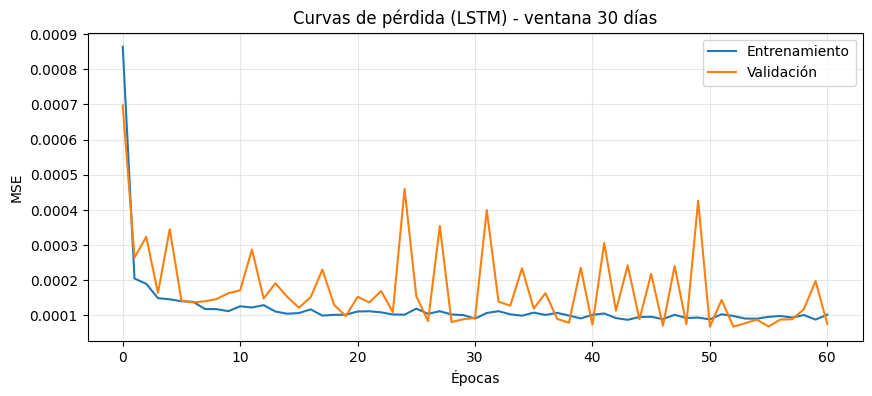

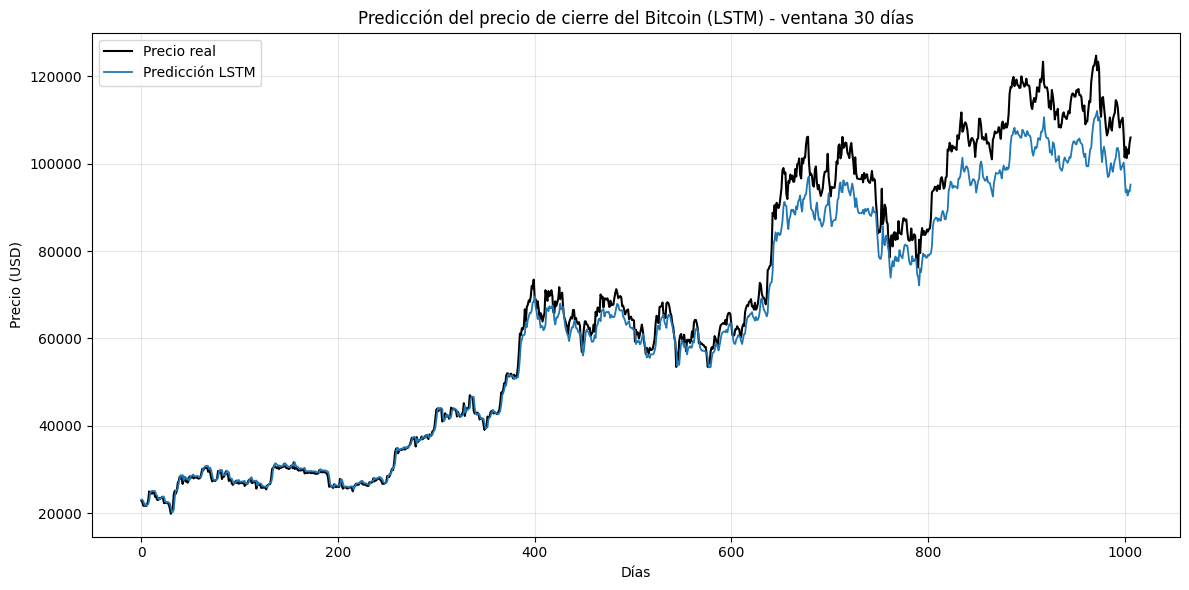


 Entrenando modelo RNN con ventana = 90 días...


c:\Users\alanm\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
📊 RNN (90 días) -> MAE: 4022.28 | RMSE: 5452.59 | R²: 0.9698


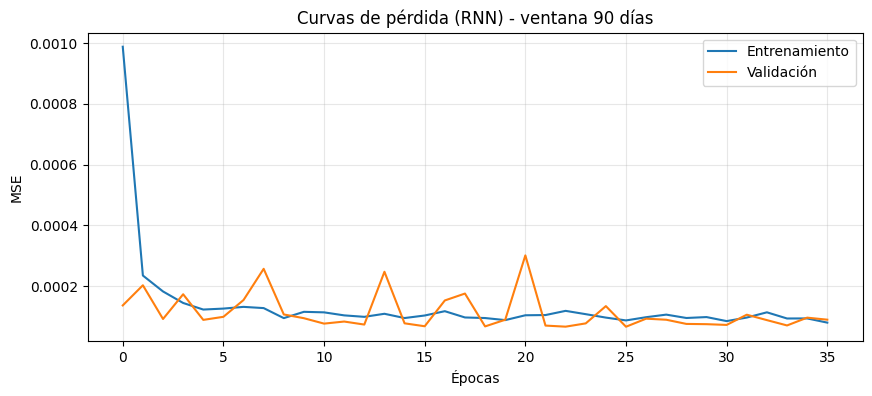

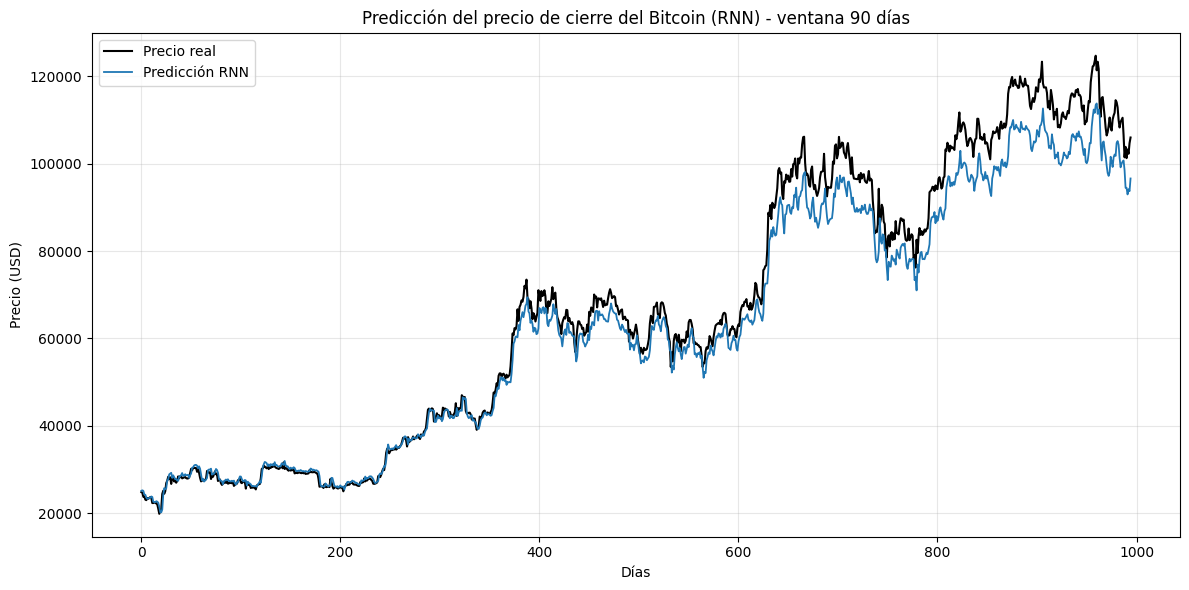


 Entrenando modelo LSTM con ventana = 90 días...


c:\Users\alanm\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
📊 LSTM (90 días) -> MAE: 4194.12 | RMSE: 5704.44 | R²: 0.9669


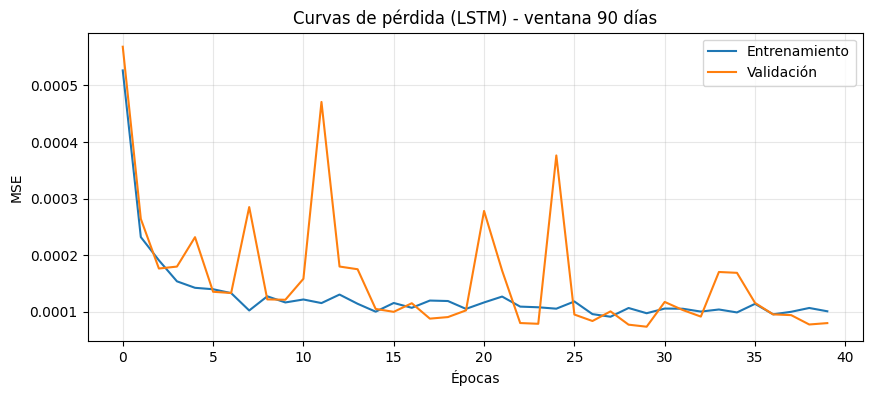

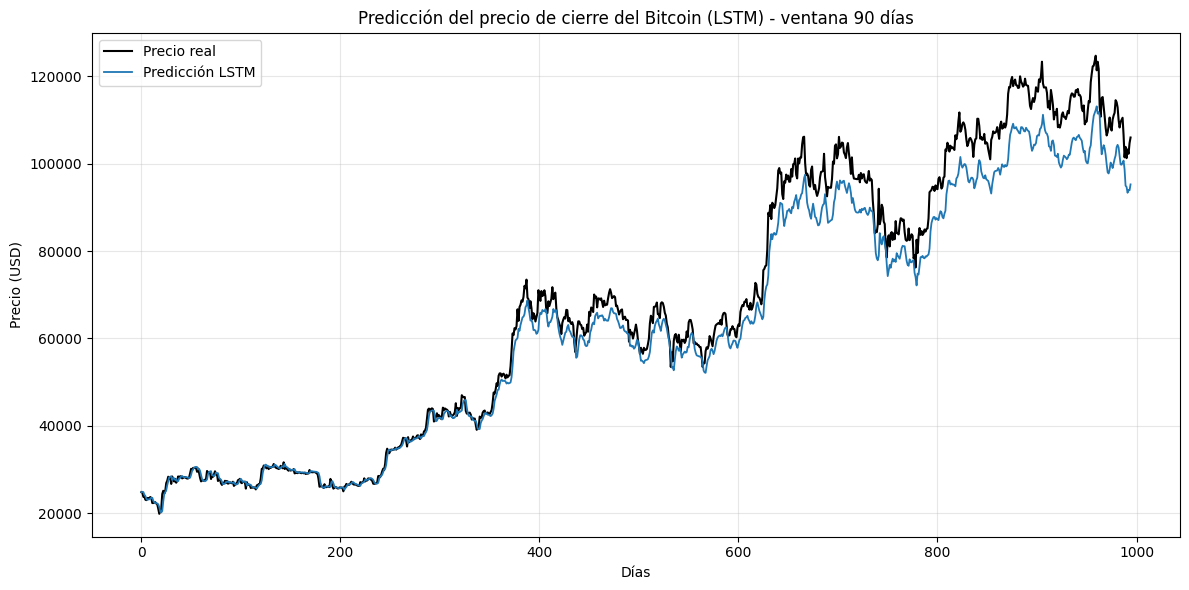


📈 Resultados finales comparativos:


,Modelo,Ventana,MAE,RMSE,R²
0,RNN,7,3038.393111,4210.562848,0.982246
1,LSTM,7,3329.740161,4533.061396,0.979423
2,RNN,14,2162.769918,3014.657495,0.990885
3,LSTM,14,4418.888945,5997.423898,0.963924
4,RNN,30,4186.042591,5677.277628,0.967591
5,LSTM,30,4046.986249,5773.823179,0.966479
6,RNN,90,4022.279527,5452.594564,0.969787
7,LSTM,90,4194.122166,5704.439629,0.966931


In [33]:
ventanas = [7, 14, 30, 90]
resultados = []

# Entrenar modelos
for ventana in ventanas:
    X_train, X_test, y_train, y_test, scaler = preparar_datos(daily_data, ventana)
    
    for modelo in ["RNN", "LSTM"]:
        mae, rmse, r2 = entrenar_modelo(modelo, X_train, y_train, X_test, y_test, scaler, ventana)
        resultados.append([modelo, ventana, mae, rmse, r2])

# Mostrar tabla final de resultados
resultados_df = pd.DataFrame(resultados, columns=["Modelo", "Ventana", "MAE", "RMSE", "R²"])
print("\n📈 Resultados finales comparativos:")
display(resultados_df)

## Justificación de Decisiones de Diseño

### Arquitectura seleccionada
Se implementaron dos arquitecturas de redes recurrentes para modelar la secuencia temporal de los precios del Bitcoin:
- **RNN (Recurrent Neural Network)**: modelo base con una capa recurrente simple.
- **LSTM (Long Short-Term Memory)**: modelo con puertas de control para manejar dependencias de largo plazo.

### Función de costo
Se utilizó la **pérdida de error cuadrático medio (MSE)**, apropiada para tareas de regresión continua. Esta función **penaliza de forma más fuerte los errores grandes**, lo cual es ideal para problemas financieros donde desviaciones pequeñas pueden tener alto impacto.

### Inicialización de pesos
Las capas densas con activación `ReLU` utilizaron la inicialización **He Normal**, que ajusta la varianza de los pesos según el número de neuronas de entrada. La inicialización `He` mejora el aprendizaje en capas `ReLU`, mientras que `Xavier` es ideal para activaciones simétricas como `tanh`.

### Función de activación
- **tanh** en las capas recurrentes: centra las salidas entre -1 y 1, lo que facilita la estabilidad numérica en secuencias temporales.
- **ReLU** en las capas densas intermedias.
- **Lineal (sin activación)** en la capa de salida, ya que el objetivo es predecir un valor continuo (el precio de cierre).

### Regularización
Para garantizar un aprendizaje estable y evitar sobreajuste, se aplicaron:  
  - **Dropout (0.2)**: desactiva el 20% de las neuronas durante el entrenamiento, obligando a la red a generalizar mejor.
  - **EarlyStopping (patience=10)**: detiene automáticamente el entrenamiento cuando la pérdida de validación deja de mejorar por 10 épocas, restaurando los mejores pesos alcanzados.

### Control de tasa de aprendizaje
Se usó el optimizador `Adam` con una **tasa de aprendizaje inicial de 0.001**, al ser uno de los algoritmos más robustos y estables para redes recurrentes.

### Normalización de entradas
Se aplicó **MinMaxScaler** para escalar todos los precios (Open, High, Low, Close, Volume) al rango [0, 1].
Esto evita que las magnitudes de los precios generen gradientes desbalanceados y acelera la convergencia del modelo.

### Prueba de múltiples configuraciones
Con el objetivo de **identificar la ventana temporal óptima**, se evaluaron cuatro configuraciones del parámetro `window_size`: 7, 14, 30 y 90 días. Cada configuración representa cuántos días pasados se usan para predecir el siguiente precio.

### Métricas de evaluación
- **MAE (Mean Absolute Error)**: mide el error promedio absoluto en dólares.
- **RMSE (Root Mean Squared Error)**: penaliza errores grandes.
- **R² (Coeficiente de determinación)**: mide el grado de ajuste del modelo a la variabilidad real de los datos.

## 4) Resultados e interpretación (25%)

En este proyecto se entrenaron **dos configuraciones de redes recurrentes (RNN y LSTM)** con distintas ventanas temporales **(7, 14, 30, 90 días)** para **predecir el precio de cierre diario del Bitcoin** a partir de su historial de precios.

Tras comparar sus métricas de evaluación (MAE, RMSE y R²), se observaron los siguientes resultados:

| Modelo | Ventana          | RMSE        | MAE          | R²       |
|-----------|----------------|----------------|----------------|----------------|
| RNN  | 7 | 4,210.56 | 3,038.39 | 0.9822 |
| RNN  | 7 | 4,533.06 | 3,329.74 | 0.9794 |
| **RNN**  | **14** | **3,014.65** | **2,162.77** | **0.9909** |
| RNN  | 14 | 5,997.42 | 4,418.89 | 0.9639 |
| RNN  | 30 | 5,677.2  | 4,186.04 | 0.9676 |
| RNN  | 30 | 5,773.82 | 4,046.99 | 0.9665 |
| RNN  | 90 | 5,452.59 | 4,022.28 | 0.9698 |
| RNN  | 90 | 5,704.43 | 4,194.12| 0.9669 |

### Interpretación de resultados
- La **RNN** superó consistentemente a la **LSTM** en todas las configuraciones, con menores errores y mayor coeficiente de determinación (R²).
- El mejor desempeño lo mostro la **RNN de 14 días**, alcanzando un **MAE de 2,162 USD** y **R² de 0.9909**, lo que significa que el modelo logra explicar el **99%** de la variabilidad del precio real.
- Las **ventanas cortas (7-14 días)** resultaron más eficientes para capturar el movimiento del mercado, mientras que las **ventanas largas (30-90 días)** tendieron a suavizar las fluctuaciones.

Se seleccionó la RNN con ventana de 14 días como modelo final porque:
1. Presenta mejor equilibrio entre precisión y estabilidad.
2. Tiene una arquitectura más simple que generaliza mejor y evita sobreajuste.
3. Requiere menor costo computacional.


## 5) Conclusión (5%)

En este notebook se desarrolló un flujo completo de trabajo en Deep Learning para la **predicción del precio de cierre diario del Bitcoin, empleando redes neuronales recurrentes (RNN y LSTM)**.

#### 1. Exploración y Preparación de Datos:
Se utilizó un dataset histórico de precios de Bitcoin con registros desde 2012, conteniendo variables como `Open`, `High`, `Low`, `Close` y `Volume`.

Los datos fueron ordenados cronológicamente y normalizados con **MinMaxScaler**, garantizando estabilidad numérica y un aprendizaje eficiente.

Se generaron ventanas deslizantes de 7, 14, 30 y 90 días, permitiendo evaluar el efecto del contexto temporal en la precisión del modelo.

#### 2. Desarrollo del modelo:
Se implementaron dos arquitecturas:
- **RNN (Recurrent Neural Network)**: con activación `tanh`, capa intermedia `ReLU`, regularización `Dropout (0.2)` y control de entrenamiento mediante `EarlyStopping`.
- **LSTM (Long Short-Term Memory)**: Lo mismo que **RNN** pero con celdas de memoria extendida para capturar dependencias de largo plazo.

#### 3. Resultados
Tras evaluar todas las configuraciones obtuvimos que el mejor modelo fue la **RNN con ventana de 14 días**, con:
- **MAE**: 2,162.77 USD
- **RMSE**: 3,014.65 USD
- **R²**: 0.9909

Esto nos dice que los **patrones de corto plazo** del mercado son los más relevantes para la predicción de precios diarios.

#### 4. Conclusiones finales:
Aunque el modelo logra resultados sobresalientes en métricas de evaluación (por ejemplo **R²**: 0.9909), su capacidad de aplicación en la vida real es limitada por **factores externos**.

En entornos financieros reales, el precio del Bitcoin depende de variables no incluidas en el dataset (noticias, sentimiento social, decisiones económicas, etc). Por tanto, este modelo **no busca anticipar eventos inesperados, sino aproximar el comportamiento esperado bajo condiciones normales del mercado. Para un uso real se requeriría integrar de más fuentes de información.
